In [1]:
import os
import json
import math
import numpy as np
import torch
import pytorch_lightning as pl
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel

/Users/ahmedmohammed/opt/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(array([ 4.,  6., 15., 14., 11., 17., 20., 19., 34., 46., 43., 39., 50.,
        28., 32.]),
 array([16.        , 20.86666667, 25.73333333, 30.6       , 35.46666667,
        40.33333333, 45.2       , 50.06666667, 54.93333333, 59.8       ,
        64.66666667, 69.53333333, 74.4       , 79.26666667, 84.13333333,
        89.        ]),
 <BarContainer object of 15 artists>)

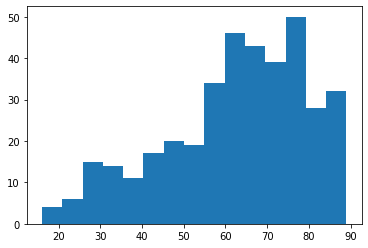

In [2]:
data_train = np.load('data_train.npy')
data_val = np.load('data_val.npy')
data_test = np.load('data_test.npy')

plt.hist(data_val, bins=15)

In [3]:
train_mean, train_std = data_train.mean(), data_train.std()

data_train = (data_train - train_mean) / train_std
data_val = (data_val - train_mean) / train_std

In [4]:
with open("logs.json", "w") as f:
    json.dump({'train_mean': train_mean.item(),
                 'train_std': train_std.item()}, f, indent=2)

In [5]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, nums):
        self.nums = nums
    
    
    def __len__(self):
        return len(self.nums)
    
    
    def __getitem__(self, index):
        return self.nums[index].unsqueeze(0)

In [6]:
def gauusian_kernel_mmd(x, y, gamma=1):
    # x: (b, no_features)
    # y: (b, no_features)
    b = x.shape[0]
            
    K = rbf_kernel(x, x, gamma=gamma)
    A = (K.sum() - K.diagonal().sum()) / (b * (b - 1))

    K = rbf_kernel(y, y, gamma=gamma)
    C = (K.sum() - K.diagonal().sum()) / (b * (b - 1))

    K = rbf_kernel(x, y, gamma=gamma)
    B = 2 * (K.sum() / (b * b))

    return A - B + C
    

In [7]:
class Generator(torch.nn.Module):
    def __init__(self, gen_tup):
        super().__init__()
        
        # Always set the normalization of the last layer to False
        # ((3, False), (5, True), (10, True), (5, False))
        
        layers = []
        for i in range(len(gen_tup) - 1):
            in_feat, norm = gen_tup[i]
            out_feat, _ = gen_tup[i + 1]
            layers.append(torch.nn.Linear(in_feat, out_feat))
            if norm:
                layers.append(torch.nn.BatchNorm1d(out_feat))
            layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
        
        # last dimension must be 1
        in_feat, norm = gen_tup[-1]
        layers.append(torch.nn.Linear(in_feat, 1))
        if norm:
            layers.append(torch.nn.BatchNorm1d(1))
        #layers.append(torch.nn.ReLU(inplace=True))

        self.model = torch.nn.Sequential(*layers)
        
    
    def forward(self, n):
        # n: (b, noise_dim)
        x = self.model(n)     # x: (b, 1)
        return x

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, disc_tup):
        super().__init__()
        
        # ((5, False), (10, False), (5, False))
        out_feat, norm = disc_tup[0]
        layers = [torch.nn.Linear(1, out_feat)]
        if norm:
            layers.append(torch.nn.BatchNorm1d(out_feat))
        layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
        
        for i in range(len(disc_tup) - 1):
            in_feat, _ = disc_tup[i]
            out_feat, norm = disc_tup[i + 1]
            layers.append(torch.nn.Linear(in_feat, out_feat))
            if norm:
                layers.append(torch.nn.BatchNorm1d(out_feat))
            layers.append(torch.nn.LeakyReLU(0.2, inplace=True))
        
        # Last layer maps last out_feat to 1 for binary classification
        layers.append(torch.nn.Linear(out_feat, 1))
        
        self.model = torch.nn.Sequential(*layers)
    
    
    def forward(self, x):
        # x: (b, 1) ===> Either real/fake
        y = self.model(x)        # y: (b, 1)
        return y.squeeze(-1)     # y: (b,)

In [9]:
class GAN(pl.LightningModule):
    def __init__(self, gen_tup, disc_tup):
        super().__init__()
        
        noise_dim, _ = gen_tup[0]
        self.register_buffer('noise_dim', torch.tensor(noise_dim))
        
        if (self.global_rank == 0) and ('data_val' in globals()):
            self.validation_n = torch.randn(
                len(data_val), noise_dim,
                device=self.device
            )
        
        self.gen = Generator(gen_tup)
        self.disc = Discriminator(disc_tup)
        
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.automatic_optimization = False
    
    
    def forward(self, n):
        return self.gen(n)
    
    
    def training_step(self, batch, batch_idx):
        # batch: (b, 1)
        b = batch.shape[0]
        
        gen_opt, disc_opt = self.optimizers()
        
        ##########################
        # Optimize Discriminator #
        ##########################
        real_logits = self.disc(batch)     # (b,)
        ones_labels = torch.ones_like(real_logits)
        real_disc_loss = self.criterion(real_logits, ones_labels)
        
        n = torch.randn(b, self.noise_dim.item(), device=self.device)
        x = self.gen(n)     # x: (b, 1)
        
        fake_logits = self.disc(x.detach())     # (b,)
        zeros_labels = torch.zeros_like(fake_logits)
        fake_disc_loss = self.criterion(fake_logits, zeros_labels)
        
        disc_loss = real_disc_loss + fake_disc_loss
        
        disc_opt.zero_grad()
        self.manual_backward(disc_loss)
        disc_opt.step()
        
        ######################
        # Optimize Generator #
        ######################
        gen_logits = self.disc(x)
        #gen_loss = self.criterion(gen_logits, ones_labels)
        gen_loss = torch.mean(-torch.log(torch.sigmoid(gen_logits)))
        
        gen_opt.zero_grad()
        self.manual_backward(gen_loss)
        gen_opt.step()
        
        return {
            'gen_loss': gen_loss.detach(),
            'disc_loss': disc_loss.detach()
        }
        
    
    def train_dataloader(self):
        train_dataset = TrainDataset(torch.tensor(data_train, dtype=torch.float32))
        return torch.utils.data.DataLoader(
            train_dataset, batch_size=len(train_dataset), shuffle=True,
            num_workers=0, drop_last=True
        )
    
    
    def configure_optimizers(self):
        gen_opt = torch.optim.Adam(self.gen.parameters(), lr=1e-4)
        disc_opt = torch.optim.Adam(self.disc.parameters(), lr=1e-4)
        return gen_opt, disc_opt
    
    
    def on_train_epoch_end(self):
        global min_val_mmd, best_gen_model_state, val_mmd
        
        self.eval()
        with torch.no_grad():
            if self.global_rank == 0:
                # refer to https://www.kaggle.com/code/onurtunali/maximum-mean-discrepancy/notebook

                if 'data_val' not in globals():
                    raise NameError('No "data_val" local variable to validate!')

                x = self.gen(self.validation_n).numpy()
                y = np.expand_dims(data_val, -1)
                
                # mmd is computed on normalized data
                mmd = gauusian_kernel_mmd(x, y, gamma=1)
                val_mmd.append(mmd.item())

                if mmd < min_val_mmd:
                    min_val_mmd = mmd
                    best_gen_model_state = deepcopy(self.gen.state_dict())
                    #print(f'mmd = {round(mmd, 2)} .... min_val_mmd = {round(min_val_mmd, 2)}')
            
        self.train()

In [10]:
# 2 hyperparameters:
# 1) gen tuple: 1st sub_tuple in tuple corresponds to noise (latent) dimension
# 2) disc tuple

# Always set the normalization of the last layer in gen to False
hyperp_list = [
    [((3, False), (5, True), (10, True), (5, False)),
     ((5, False), (10, False), (5, False))],
    
    [((4, False), (6, True), (8, True), (6, True), (3, False)),
     ((3, False), (6, False), (9, False), (6, False), (3, False))],
    
    [((8, False), (10, True), (12, True), (10, True), (8, True), (6, True), (4, False)),
     ((3, False), (6, False), (9, False), (6, False), (3, False))],
    
    [((10, False), (12, True), (14, True), (12, True), (10, True), (8, True), (6, True), (4, False)),
     ((5, False), (7, False), (9, False), (7, False), (5, False), (3, False))]
]

Global seed set to 0
/Users/ahmedmohammed/opt/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type              | Params
------------------------------------------------
0 | gen       | Generator         | 171   
1 | disc      | Discriminator     | 131   
2 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
302       Trainable params
0         Non-trainable params
302       Total params
0.001     Total estimated model params size (MB)
/Users/ahmedmohammed/opt/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lig

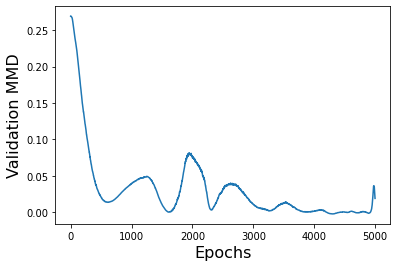

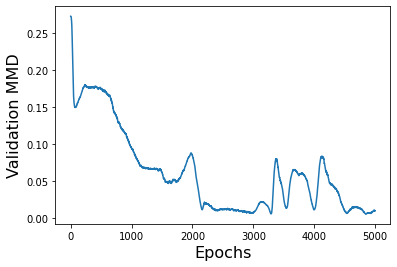

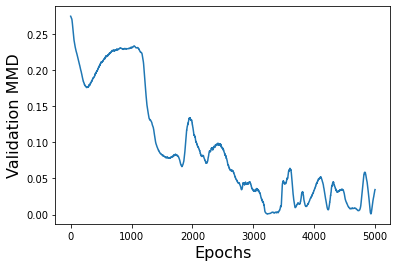

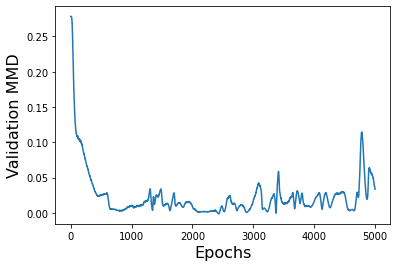

In [11]:
figs = []
for gen_tup, disc_tup in hyperp_list:
    pl.utilities.seed.seed_everything(0)
    min_val_mmd = math.inf
    best_gen_model_state = None
    val_mmd = []
    
    model = GAN(gen_tup, disc_tup)
    trainer = pl.Trainer(
        gpus=0, enable_checkpointing=False,
        enable_progress_bar=False, logger=False, max_epochs=5000
    )
    trainer.fit(model)
    
    fig, ax = plt.subplots()
    ax.plot(val_mmd)
    ax.set_xlabel('Epochs', fontsize=16)
    ax.set_ylabel('Validation MMD', fontsize=16)
    figs.append(fig)
    
    
    LOGGING = False 
    with open('./logs.json') as f:
        dic = json.load(f)
        str_id = str(gen_tup)
        if str_id in dic:
            if round(min_val_mmd.item(), 4) < dic[str_id]['min_val_mmd']:
                LOGGING = True
                dic[str_id]['min_val_mmd'] = round(min_val_mmd.item(), 4)
                fig.savefig(dic[str_id]['val_mmd_fig_path'])
                torch.save(best_gen_model_state, dic[str_id]['weights_file_path'])
        else:
            LOGGING = True
            # determine file_number
            files_names = [f for f in os.listdir('gens_weights/') if '.pt' in f]
            if len(files_names) == 0:
                file_number = 1
            else:
                max_file_name = max(files_names)
                file_number = max_file_name[1 + max_file_name.find('_') : max_file_name.find('.pt')]
                file_number = int(file_number) + 1
            
            # logging
            dic[str_id] = {
                'min_val_mmd': round(min_val_mmd.item(), 4),
                'val_mmd_fig_path': 'val_mmd_figs/gen_' + str(file_number) + '.pdf',
                'weights_file_path': 'gens_weights/gen_' + str(file_number) + '.pt'
                #'train_mean': train_mean.item(),
                #'train_std': train_std.item()
            }
            fig.savefig(dic[str_id]['val_mmd_fig_path'], bbox_inches = 'tight')
            torch.save(best_gen_model_state, dic[str_id]['weights_file_path'])
    
    
    if LOGGING:
        with open('logs.json', 'w') as f:
            json.dump(dic, f, indent=2)

## Sampling from the best trained Generator

In [329]:
import math
import json
import torch
import matplotlib.pyplot as plt

In [330]:
with open('logs.json', 'r') as f:
    dic = json.load(f)

train_mean = dic['train_mean']
train_std = dic['train_std']

In [331]:
min_val_mmd = math.inf
for key in dic:    
    if isinstance(dic[key], dict) and (0 <= dic[key]['min_val_mmd'] < min_val_mmd):
        min_val_mmd = dic[key]['min_val_mmd']
        min_val_mmd_key = key
        val_mmd_fig_path = dic[key]['val_mmd_fig_path']
        weights_file_path = dic[key]['weights_file_path']

In [332]:
gen_tup = eval(min_val_mmd_key)
gen = Generator(gen_tup)
gen.load_state_dict(torch.load(weights_file_path))

<All keys matched successfully>

In [333]:
data_test.shape

(378,)

In [334]:
noise = torch.randn((data_test.shape[0], gen_tup[0][0]))
noise.shape

torch.Size([378, 8])

In [335]:
generated_samples = gen(torch.tensor(noise)).squeeze()
generated_samples = generated_samples.detach().numpy()
generated_samples.shape

/var/folders/zt/682q44md4jlcsc02s9j38_b00000gn/T/ipykernel_8984/2666986929.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generated_samples = gen(torch.tensor(noise)).squeeze()


(378,)

(array([24., 17., 15., 11., 15., 65., 71., 19., 69., 72.]),
 array([19.165035, 25.68204 , 32.199043, 38.71605 , 45.233055, 51.75006 ,
        58.267063, 64.784065, 71.30107 , 77.81808 , 84.33508 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

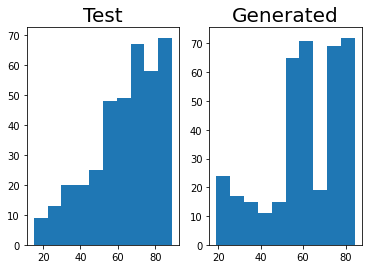

In [355]:
fig, (test_ax, gen_ax) = plt.subplots(nrows=1, ncols=2)

test_ax.set_title('Test', fontsize=20)
test_ax.hist(data_test, label='Test')

gen_ax.set_title('Generated', fontsize=20)
gen_ax.hist(train_mean + (generated_samples * train_std), label='Generated')

In [356]:
fig.savefig('distributions.pdf', bbox_inches = 'tight')